# CutMix 성능 평가 실험하기
  
## 1. CutMix를 적용한 데이터셋 만들기


In [1]:
import urllib3
import tensorflow_datasets as tfds
import tensorflow as tf

import matplotlib.pyplot as plt
import numpy as np

from Data_Aug import data_augmentation
from model import Model

In [2]:
def get_data(data_name='stanford_dogs', show_ex = False):
    '''
    tfds에서 제공하는 데이터셋
    https://www.tensorflow.org/datasets/overview
    '''
    urllib3.disable_warnings()
    (ds_train, ds_test), ds_info = tfds.load(data_name,
                                             split=['train','test'],
                                             as_supervised=True,
                                             shuffle_files=True,
                                             with_info=True,)
    if show_ex:
        fig = tfds.show_examples(ds_train,ds_info)

    return (ds_train, ds_test), ds_info

In [3]:
#GPU 체크
tf.config.set_soft_device_placement(True)
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
#데이터불러오기
(ds_train, ds_test), ds_info = get_data('stanford_dogs', show_ex=False)
data_aug = data_augmentation(ds_info)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/12000 [00:00<?, ? examples/s]

Shuffling stanford_dogs-train.tfrecord...:   0%|          | 0/12000 [00:00<?, ? examples/s]

Generating test examples...:   0%|          | 0/8580 [00:00<?, ? examples/s]

Shuffling stanford_dogs-test.tfrecord...:   0%|          | 0/8580 [00:00<?, ? examples/s]

Dataset stanford_dogs downloaded and prepared to /home/aiffel0042/tensorflow_datasets/stanford_dogs/0.2.0. Subsequent calls will reuse this data.


## 2. 모델 구성하기
---
Augmentation이 적용된 데이터와 적용되지 않은 데이터를 가지고 실험하기위해  
두 데이터셋에 동일한 모델을 적용시켜야한다.  
이 project에서는 ResNet-50을 사용한다.

In [5]:
#데이터셋 구성하기
ds_train_pure = data_aug.apply_normalize_on_dataset(ds_train,
                                                    is_test=False,
                                                    batch_size=16,
                                                    with_aug=False,
                                                    with_cutmix=False)
ds_train_aug_only = data_aug.apply_normalize_on_dataset(ds_train,
                                                        is_test=False,
                                                        batch_size=16,
                                                        with_aug=True,
                                                        with_cutmix=False)
ds_train_cutmix_only = data_aug.apply_normalize_on_dataset(ds_train,
                                                           is_test=False,
                                                           batch_size=16,
                                                           with_aug=False,
                                                           with_cutmix=True)
ds_train_aug_cutmix = data_aug.apply_normalize_on_dataset(ds_train,
                                                          is_test=False,
                                                          batch_size=16,
                                                          with_aug=True,
                                                          with_cutmix=False)

In [6]:
ds_train_aug_only

<PrefetchDataset shapes: ((None, 224, 224, 3), (None, 120)), types: (tf.float32, tf.float32)>

In [7]:
ds_train_cutmix_only

<PrefetchDataset shapes: ((16, 224, 224, 3), (16, 120)), types: (tf.float32, tf.float32)>

In [8]:
#ds_train_mixup_only
#ds_train_aug_mixup
ds_test = data_aug.apply_normalize_on_dataset(ds_test,is_test=True,
                                              batch_size=16)
model_without_mix = Model(with_mix=False, ds_info=ds_info)
model_with_mix = Model(with_mix=True, ds_info=ds_info)

In [9]:
resnet_with_pure = model_without_mix.model_setting(show_summary=False)
resnet_with_aug_only = model_without_mix.model_setting(show_summary=False)
resnet_with_cutmix_only = model_with_mix.model_setting(show_summary=False)
resnet_with_aug_cutmix = model_with_mix.model_setting(show_summary=False)

## 3. 모델 훈련하기

In [10]:
from tensorflow.keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss',patience=3,verbose=1,mode='min')
EPOCHS = 15
steps_per_epoch = int(ds_info.splits['train'].num_examples/16)
validation_steps = int(ds_info.splits['test'].num_examples/16)

print(steps_per_epoch)
print(validation_steps)

750
536


#### resnet_with_pure
- model : ResNet50  
- Augmentation state : pure

### 순수 data

In [11]:
#resnet_with_pure model
history_resnet_with_pure = resnet_with_pure.fit(ds_train_pure,
                                               steps_per_epoch=steps_per_epoch,
                                               validation_steps=validation_steps,
                                               epochs=EPOCHS,
                                               validation_data=ds_test,
                                               verbose=1,
                                               callbacks=[es],
                                               use_multiprocessing=True)

Epoch 1/15
  2/750 [..............................] - ETA: 53s - loss: 5.2432 - accuracy: 0.0000e+00WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0569s vs `on_train_batch_end` time: 0.0854s). Check your callbacks.


750/750 [==============================] - 111s 149ms/step - loss: 2.2133 - accuracy: 0.4446 - val_loss: 3.3643 - val_accuracy: 0.1995
Epoch 2/15
750/750 [==============================] - 109s 146ms/step - loss: 0.7982 - accuracy: 0.7754 - val_loss: 1.0457 - val_accuracy: 0.6875
Epoch 3/15
750/750 [==============================] - 110s 146ms/step - loss: 0.2875 - accuracy: 0.9350 - val_loss: 0.9810 - val_accuracy: 0.7129
Epoch 4/15
750/750 [==============================] - 110s 146ms/step - loss: 0.0987 - accuracy: 0.9872 - val_loss: 0.9022 - val_accuracy: 0.7400
Epoch 5/15
750/750 [==============================] - 110s 146ms/step - loss: 0.0395 - accuracy: 0.9966 - val_loss: 0.9219 - val_accuracy: 0.7399
Epoch 6/15
750/750 [==============================] - 110s 146ms/step - loss: 0.0279 - accuracy: 0.9982 - val_loss: 0.9276 - val_accuracy: 0.7400
Epoch 7/15
750/750 [==============================] - 112s 149ms/step - loss: 0.0153 - accuracy: 0.9996 - val_loss: 0.9393 - val_accura

### 기본 Augmentation 적용

In [12]:
#resnet_with_aug_only model
history_resnet_with_aug_only = resnet_with_aug_only.fit(ds_train_aug_only,
                                               steps_per_epoch=steps_per_epoch,
                                               validation_steps=validation_steps,
                                               epochs=EPOCHS,
                                               validation_data=ds_test,
                                               verbose=1,
                                               callbacks=[es],
                                               use_multiprocessing=True)

Epoch 1/15
750/750 [==============================] - 111s 148ms/step - loss: 2.2269 - accuracy: 0.4410 - val_loss: 2.8032 - val_accuracy: 0.3082
Epoch 2/15
750/750 [==============================] - 112s 150ms/step - loss: 0.9543 - accuracy: 0.7301 - val_loss: 1.4258 - val_accuracy: 0.5947
Epoch 3/15
750/750 [==============================] - 111s 148ms/step - loss: 0.5272 - accuracy: 0.8549 - val_loss: 1.1070 - val_accuracy: 0.6860
Epoch 4/15
750/750 [==============================] - 112s 150ms/step - loss: 0.3226 - accuracy: 0.9164 - val_loss: 1.0216 - val_accuracy: 0.7074
Epoch 5/15
750/750 [==============================] - 113s 151ms/step - loss: 0.2071 - accuracy: 0.9509 - val_loss: 1.1375 - val_accuracy: 0.6824
Epoch 6/15
750/750 [==============================] - 112s 150ms/step - loss: 0.1118 - accuracy: 0.9787 - val_loss: 0.9975 - val_accuracy: 0.7262
Epoch 7/15
750/750 [==============================] - 112s 149ms/step - loss: 0.0585 - accuracy: 0.9919 - val_loss: 0.9387 -

### Cutmix only

In [13]:
#resnet_with_cutmix_only model
history_resnet_with_cutmix_only = resnet_with_cutmix_only.fit(ds_train_cutmix_only,
                                               steps_per_epoch=steps_per_epoch,
                                               validation_steps=validation_steps,
                                               epochs=EPOCHS,
                                               validation_data=ds_test,
                                               verbose=1,
                                               callbacks=[es],
                                               )

Epoch 1/15
  2/750 [..............................] - ETA: 49s - loss: 5.0762 - accuracy: 0.0312   WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0518s vs `on_train_batch_end` time: 0.0798s). Check your callbacks.


750/750 [==============================] - 113s 151ms/step - loss: 3.8266 - accuracy: 0.2163 - val_loss: 3.3230 - val_accuracy: 0.2199
Epoch 2/15
750/750 [==============================] - 113s 151ms/step - loss: 2.9239 - accuracy: 0.4345 - val_loss: 1.5553 - val_accuracy: 0.5682
Epoch 3/15
750/750 [==============================] - 114s 151ms/step - loss: 2.6444 - accuracy: 0.5130 - val_loss: 1.2455 - val_accuracy: 0.6522
Epoch 4/15
750/750 [==============================] - 116s 154ms/step - loss: 2.4184 - accuracy: 0.5982 - val_loss: 1.1421 - val_accuracy: 0.6848
Epoch 5/15
750/750 [==============================] - 113s 151ms/step - loss: 2.2742 - accuracy: 0.6395 - val_loss: 1.2446 - val_accuracy: 0.6531
Epoch 6/15
750/750 [==============================] - 113s 151ms/step - loss: 2.1851 - accuracy: 0.6647 - val_loss: 1.1824 - val_accuracy: 0.6806
Epoch 7/15
750/750 [==============================] - 115s 153ms/step - loss: 2.0709 - accuracy: 0.7067 - val_loss: 1.2792 - val_accura

### Aug + Cutmix

In [14]:
#resnet_with_aug_cutmix model
history_resnet_with_aug_cutmix = resnet_with_aug_cutmix.fit(ds_train_aug_cutmix,
                                               steps_per_epoch=steps_per_epoch,
                                               validation_steps=validation_steps,
                                               epochs=EPOCHS,
                                               validation_data=ds_test,
                                               verbose=1,
                                               callbacks=[es],
                                               use_multiprocessing=True)

Epoch 1/15
750/750 [==============================] - 110s 146ms/step - loss: 2.2218 - accuracy: 0.4469 - val_loss: 2.5261 - val_accuracy: 0.3577
Epoch 2/15
750/750 [==============================] - 110s 146ms/step - loss: 0.9476 - accuracy: 0.7241 - val_loss: 1.2937 - val_accuracy: 0.6248
Epoch 3/15
750/750 [==============================] - 110s 146ms/step - loss: 0.5234 - accuracy: 0.8566 - val_loss: 1.1339 - val_accuracy: 0.6736
Epoch 4/15
750/750 [==============================] - 110s 146ms/step - loss: 0.2781 - accuracy: 0.9308 - val_loss: 1.0405 - val_accuracy: 0.7018
Epoch 5/15
750/750 [==============================] - 110s 146ms/step - loss: 0.1639 - accuracy: 0.9661 - val_loss: 1.0204 - val_accuracy: 0.7162
Epoch 6/15
750/750 [==============================] - 110s 146ms/step - loss: 0.1252 - accuracy: 0.9745 - val_loss: 1.0791 - val_accuracy: 0.7016
Epoch 7/15
750/750 [==============================] - 110s 146ms/step - loss: 0.0882 - accuracy: 0.9847 - val_loss: 1.0699 -

## 4. 모델 결과 시각화 하기

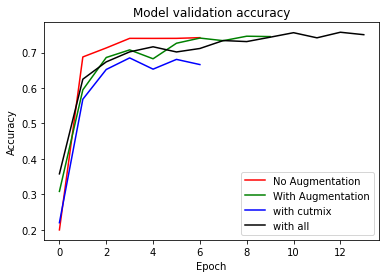

In [20]:
plt.plot(history_resnet_with_pure.history['val_accuracy'], 'r')
plt.plot(history_resnet_with_aug_only.history['val_accuracy'], 'g')
plt.plot(history_resnet_with_cutmix_only.history['val_accuracy'], 'b')
plt.plot(history_resnet_with_aug_cutmix.history['val_accuracy'], 'k')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation', 'with cutmix', 'with all'], loc='lower right')
plt.show()

확대해서 plot하기

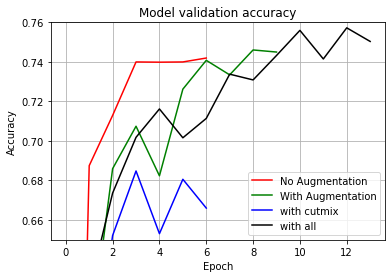

In [23]:
resnet_with_aug_cutmix
plt.plot(history_resnet_with_pure.history['val_accuracy'], 'r')
plt.plot(history_resnet_with_aug_only.history['val_accuracy'], 'g')
plt.plot(history_resnet_with_cutmix_only.history['val_accuracy'], 'b')
plt.plot(history_resnet_with_aug_cutmix.history['val_accuracy'], 'k')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation', 'with cutmix', 'with all'], loc='lower right')
plt.grid(True)
plt.ylim(0.65, 0.76)
plt.show()

## 5. Augmentation에 의한 모델 성능 비교
>No Augmentation, 기본 Augmentation, 기본 + CutMix 적용, 기본 + Mixup 적용 이상 4가지 경우의 데이터셋에 대해 훈련된 ResNet50 분류기의 견종 분류 정확도 성능을 비교해 보고, Augmentation 방법들의 영향도에 대해 분석해 보세요.

이번 Augmentation toy project에 사용한 Augmentation 기법으로  
- 기본 Augmentation : 좌우반전, 색변화 keras API  
- Cutmix : 하나의 이미지를 랜덤 crop한 다음 다른 이미지에 합성하는 기법  
- 기본 Augmentation + Cutmix : 기본 Augmentation과 Cutmix를 동시에 수행  
위와 같이 총 세가지 기법을 사용하였다.  
  
성능 비교실험을 위하여 분류모델은 keras에서 제공하는 ResNet50을 사용하였다.  
  
총 4가지 데이터로 학습을 해보았다. early stopping을 적용하여 정확도가 떨어지는 것을 방지하였다.  
  
#### early stopping으로 끝난 epoch에서 최대 정확도를 얻을 수 있었고  

- No Augmentation : 7epoch에 Val Acc : 0.7420[3rd]  
- 기본 Augmentation : 10epoch Val Acc: 0.7450[2nd]  
- Cutmix : 7epoch Val Acc : 0.666[4th]  
- 기본 Augmentation + Cutmix : 14epoch Val Acc: 0.7503[1st]  
  
#### 최소 epoch(7epoch)일때 정확도 평가
  
- No Augmentation : Val Acc : 0.7420[1st]  
- 기본 Augmentation : Val Acc: 0.7408[2nd]  
- Cutmix : Val Acc : 0.666[4th]  
- 기본 Augmentation + Cutmix : Val Acc: 0.7114[3rd]  
  
최소 epoch 기준으로는 오히려 아무런 Augmentation을 주지 않은 데이터로 학습한 모델의 성능이 더 좋았지만,  
최적의 성능까지 학습한 모델에서는 기본 Augmentation에 cutmix까지 더하여 학습한 모델의 성능이 가장 좋게 나왔다.